# **Libraries**

In [1]:
import pandas as pd
import numpy as np
import optuna
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
import seaborn as sns
import matplotlib.pyplot as plt

# **Load and Preporcessing**

In [2]:
# Load data
train = pd.read_csv("/kaggle/input/f-1-racer-diet-planning/train.csv")
test = pd.read_csv("/kaggle/input/f-1-racer-diet-planning/test.csv")
ids = test['id']

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [5]:
# Check for missing values
print("Training missing values:\n", train.isna().sum())
print("Test missing values:\n", test.isna().sum())

Training missing values:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64
Test missing values:
 id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
dtype: int64


In [6]:
# Remove duplicates
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [7]:
# Outlier capping
def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.05)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)
    return df

In [8]:
train_numeric = train.select_dtypes(include=[float, int]).columns
train_numeric

Index(['id', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')

In [9]:
train = cap_outliers_iqr(train, train_numeric)
test = cap_outliers_iqr(test, train_numeric[:-1])

In [10]:
# Skewness
train_skewness = train[train_numeric].skew()
test_skewness = test[train_numeric[:-1]].skew()

# Identify columns with |skewness| > 1
train_high_skew = train_skewness[np.abs(train_skewness) > 1].index.tolist()
test_high_skew = test_skewness[np.abs(test_skewness) > 1].index.tolist()

print("Train Columns with |Skewness| > 1:", train_high_skew)
print("Test Columns with |Skewness| > 1:", test_high_skew)

Train Columns with |Skewness| > 1: ['Body_Temp']
Test Columns with |Skewness| > 1: ['Body_Temp']


In [11]:
train['Body_Temp'].skew() # Left-Skewness

-1.0223613156737141

In [12]:
# Reflect and apply log transformation
train['Body_Temp_reflect_log'] = np.log1p(max(train['Body_Temp']) + 1 - train['Body_Temp'])
test['Body_Temp_reflect_log'] = np.log1p(max(test['Body_Temp']) + 1 - test['Body_Temp'])
train['Body_Temp_reflect_log'].skew()

0.5991487191901743

In [13]:
train.drop(['Body_Temp'], axis=1, inplace=True)
test.drop(['Body_Temp'], axis=1, inplace=True)

In [14]:
# VIF
# Select only numeric columns
train_numeric = train.select_dtypes(include=[float, int])

# Create VIF DataFrame
vif_data = pd.DataFrame()
vif_data["Variable"] = train_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(train_numeric.values, i) for i in range(train_numeric.shape[1])]

print(vif_data)

                Variable          VIF
0                     id     3.995430
1                    Age    10.341741
2                 Height  1482.814414
3                 Weight   269.663777
4               Duration   110.044112
5             Heart_Rate   431.551035
6               Calories    62.780556
7  Body_Temp_reflect_log   192.647540


In [15]:
# Encoding
train = pd.get_dummies(train, columns=['Sex'], drop_first=True)
test = pd.get_dummies(test, columns=['Sex'], drop_first=True)

In [16]:
# Feature engineering
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    df['HR_Intensity'] = df['Heart_Rate'] / (220 - df['Age'])
    df['HR_Duration'] = df['Heart_Rate'] * df['Duration']

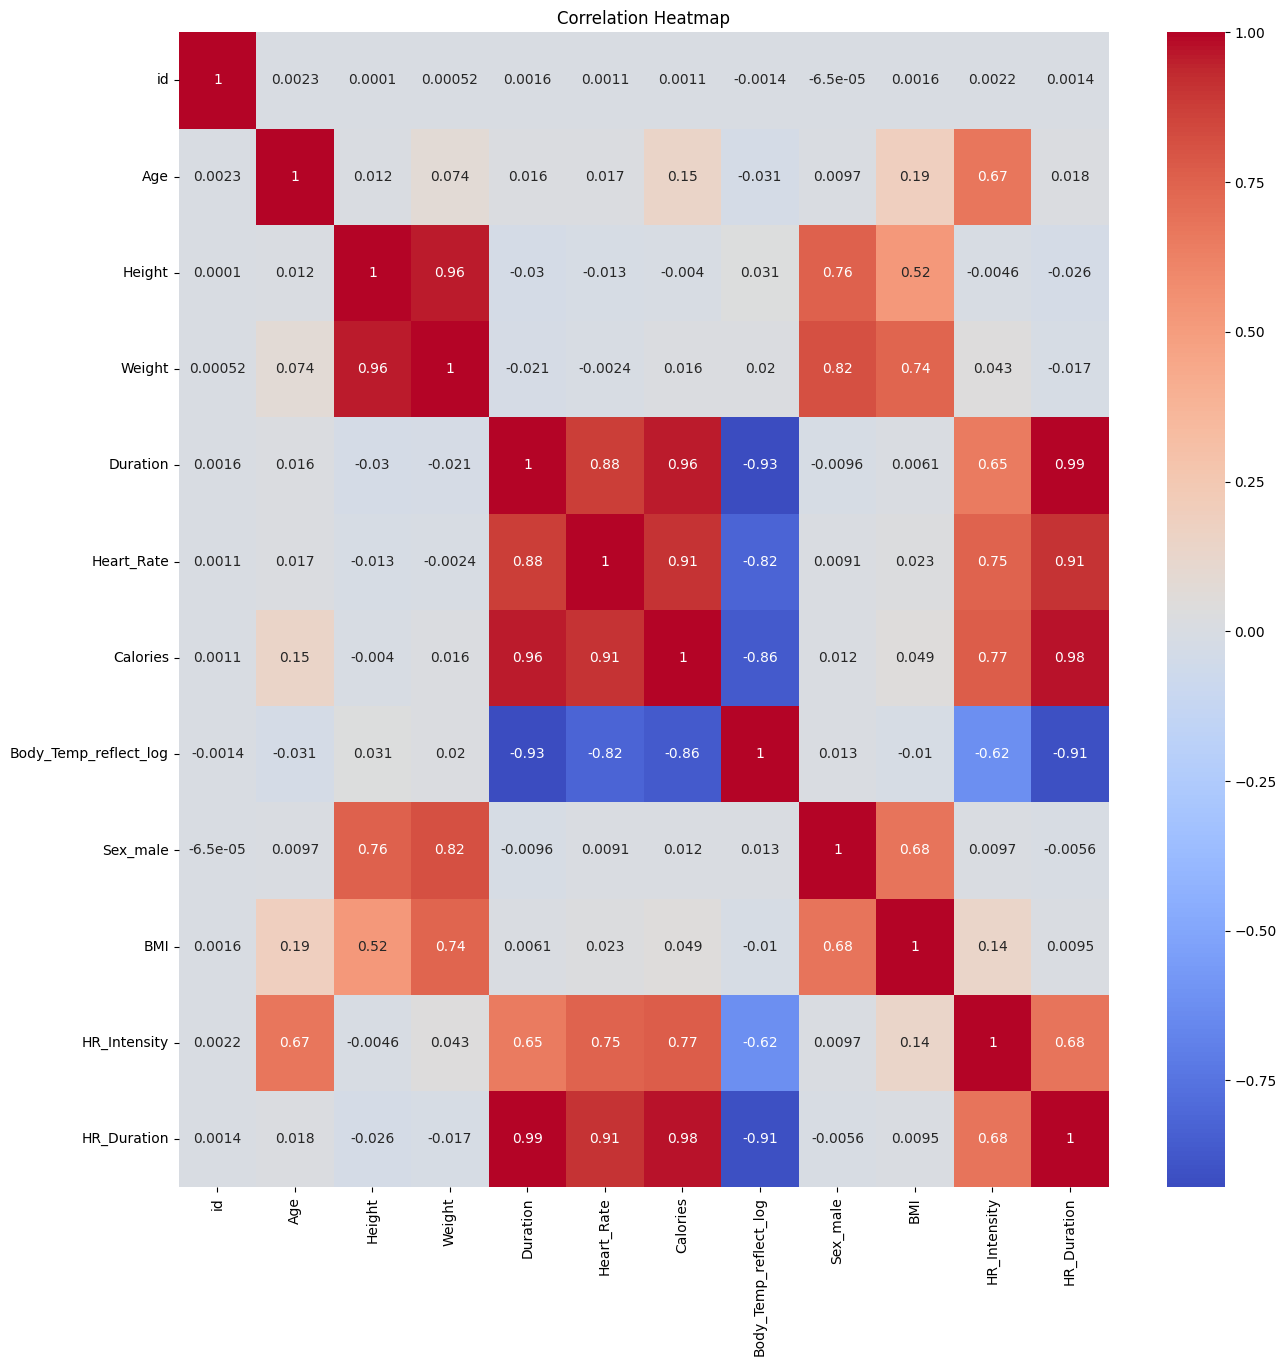

In [17]:
# Correlation heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [18]:
train_numeric = train.select_dtypes(include=[float, int])

# Create VIF DataFrame
vif_data = pd.DataFrame()
vif_data["Variable"] = train_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(train_numeric.values, i) for i in range(train_numeric.shape[1])]

print(vif_data)

                 Variable          VIF
0                      id     3.999859
1                     Age   443.813862
2                  Height  2600.565008
3                  Weight   652.391258
4                Duration  1230.033688
5              Heart_Rate  7833.283107
6                Calories   207.638514
7   Body_Temp_reflect_log   342.123466
8                     BMI   827.879698
9            HR_Intensity  7114.597693
10            HR_Duration  1779.405962


In [19]:
# Prepare data
X = train.drop(['id' ,'Calories'], axis=1)
y = train['Calories']
X_test = test.drop(['id'], axis=1)
ids = test['id']

# **Feature Selection & Modeling**

In [20]:
X.columns

Index(['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate',
       'Body_Temp_reflect_log', 'Sex_male', 'BMI', 'HR_Intensity',
       'HR_Duration'],
      dtype='object')

In [20]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

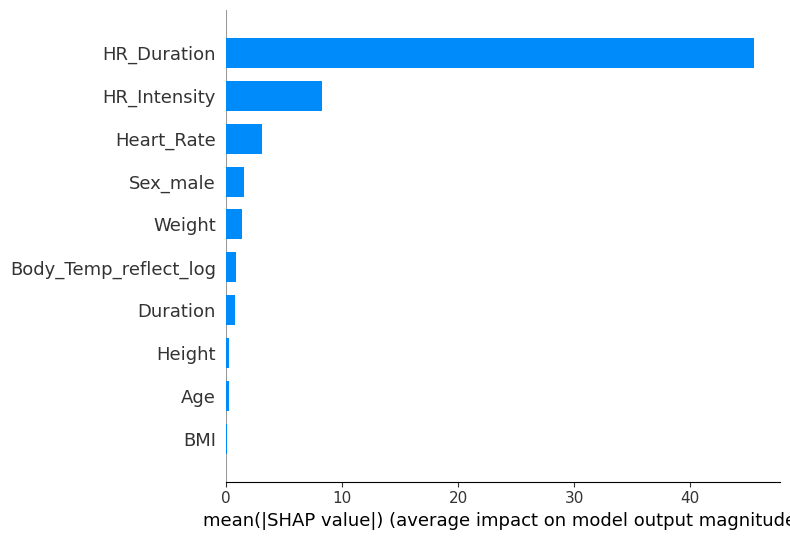

In [22]:
# Feature Selection
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
explainer = shap.Explainer(xgb)
shap_values = explainer(X)

shap.summary_plot(shap_values, X_train, plot_type='bar')

In [21]:
important_features = ['HR_Duration', 'HR_Intensity', 'Heart_Rate', 'Sex_male', 'Weight']

X_train = X_train[important_features]
X_val = X_val[important_features]
X_test = X_test[important_features]

In [22]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [25]:
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }
    model = LGBMRegressor(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)
best_lgb = LGBMRegressor(**study_lgb.best_params)

[I 2025-08-07 15:56:00,144] A new study created in memory with name: no-name-d599c2eb-85cb-42bd-8f48-f143a877516b


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 15:56:15,478] Trial 0 finished with value: 3.602380200132017 and parameters: {'n_estimators': 895, 'learning_rate': 0.10760892888350145, 'max_depth': 9, 'subsample': 0.5936726341609283, 'colsample_bytree': 0.9978685720715408, 'reg_alpha': 0.10664188012391251, 'reg_lambda': 0.3269662755617644}. Best is trial 0 with value: 3.602380200132017.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 15:56:24,422] Trial 1 finished with value: 3.6013568517212455 and parameters: {'n_estimators': 488, 'learning_rate': 0.08484104957208609, 'max_depth': 7, 'subsample': 0.7163311034593988, 'colsample_bytree': 0.9774059153842471, 'reg_alpha': 0.6719114929965709, 'reg_lambda': 0.7344405787073301}. Best is trial 1 with value: 3.6013568517212455.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 15:56:36,723] Trial 2 finished with value: 3.59459045349178 and parameters: {'n_estimators': 711, 'learning_rate': 0.09562017724315412, 'max_depth': 8, 'subsample': 0.7936355809837929, 'colsample_bytree': 0.9000891518254136, 'reg_alpha': 0.8737318355906446, 'reg_lambda': 0.9302766418940733}. Best is trial 2 with value: 3.59459045349178.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 15:56:54,866] Trial 3 finished with value: 3.5833745061289703 and parameters: {'n_estimators': 846, 'learning_rate': 0.038421623634153905, 'max_depth': 8, 'subsample': 0.5708684923252509, 'colsample_bytree': 0.9290135494068765, 'reg_alpha': 0.16924621371755533, 'reg_lambda': 0.6456418497829337}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:57:02,108] Trial 4 finished with value: 3.5922539779775224 and parameters: {'n_estimators': 365, 'learning_rate': 0.08118381301256476, 'max_depth': 9, 'subsample': 0.7292141994586687, 'colsample_bytree': 0.7827734338312307, 'reg_alpha': 0.17123922140876435, 'reg_lambda': 0.4464012575452181}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:57:07,213] Trial 5 finished with value: 3.6541110904392475 and parameters: {'n_estimators': 246, 'learning_rate': 0.16731638114428968, 'max_depth': 10, 'subsample': 0.6153025663836168, 'colsample_bytree': 0.6254257234287149, 'reg_alpha': 0.9100412515890086, 'reg_lambda': 0.07145593529300076}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 15:57:13,084] Trial 6 finished with value: 3.615281895194407 and parameters: {'n_estimators': 305, 'learning_rate': 0.09738212227338934, 'max_depth': 8, 'subsample': 0.6610955907007475, 'colsample_bytree': 0.99839399646987, 'reg_alpha': 0.17714922506142472, 'reg_lambda': 0.3695124240062434}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:57:23,223] Trial 7 finished with value: 3.614195678206792 and parameters: {'n_estimators': 628, 'learning_rate': 0.13913310595226433, 'max_depth': 11, 'subsample': 0.5984083669276259, 'colsample_bytree': 0.9194873458812933, 'reg_alpha': 0.6559183050041216, 'reg_lambda': 0.9185991882563934}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:57:42,240] Trial 8 finished with value: 3.596417752741133 and parameters: {'n_estimators': 985, 'learning_rate': 0.1014928349347493, 'max_depth': 11, 'subsample': 0.8832917646423439, 'colsample_bytree': 0.5349535814614261, 'reg_alpha': 0.5432984591528568, 'reg_lambda': 0.8358719715793973}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 15:57:59,369] Trial 9 finished with value: 3.603818467748243 and parameters: {'n_estimators': 839, 'learning_rate': 0.1548472597411541, 'max_depth': 6, 'subsample': 0.6134188889042784, 'colsample_bytree': 0.6576480166656776, 'reg_alpha': 0.8876659111420999, 'reg_lambda': 0.7140513088648248}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 15:58:09,155] Trial 10 finished with value: 3.9538203237386713 and parameters: {'n_estimators': 760, 'learning_rate': 0.03202517772067546, 'max_depth': 3, 'subsample': 0.9852883582813943, 'colsample_bytree': 0.8088720806592781, 'reg_alpha': 0.3443110544157352, 'reg_lambda': 0.5458339015442065}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 15:58:17,414] Trial 11 finished with value: 3.6264160457039805 and parameters: {'n_estimators': 419, 'learning_rate': 0.047298113764952535, 'max_depth': 5, 'subsample': 0.5091804789926015, 'colsample_bytree': 0.7789356195078553, 'reg_alpha': 0.009625595851056074, 'reg_lambda': 0.5305498443842256}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:58:22,377] Trial 12 finished with value: 3.630080949478125 and parameters: {'n_estimators': 186, 'learning_rate': 0.06228565518891877, 'max_depth': 12, 'subsample': 0.7961391376646949, 'colsample_bytree': 0.849512130557147, 'reg_alpha': 0.2777107294688038, 'reg_lambda': 0.3200844212127534}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:58:30,702] Trial 13 finished with value: 3.597688193739838 and parameters: {'n_estimators': 396, 'learning_rate': 0.060629261822846475, 'max_depth': 9, 'subsample': 0.5030054425854485, 'colsample_bytree': 0.7129713870743202, 'reg_alpha': 0.3843016866064681, 'reg_lambda': 0.6259531560724653}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 15:58:41,268] Trial 14 finished with value: 3.599157111052396 and parameters: {'n_estimators': 595, 'learning_rate': 0.07229328399940843, 'max_depth': 5, 'subsample': 0.7069958796535047, 'colsample_bytree': 0.8675560455874471, 'reg_alpha': 0.23644058626045666, 'reg_lambda': 0.08028377600846681}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:58:44,084] Trial 15 finished with value: 3.663806783594919 and parameters: {'n_estimators': 111, 'learning_rate': 0.12808792402342628, 'max_depth': 7, 'subsample': 0.8653101181515318, 'colsample_bytree': 0.7235263315224351, 'reg_alpha': 0.0035053124762212673, 'reg_lambda': 0.4072181523139133}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:58:54,687] Trial 16 finished with value: 3.5978268035467202 and parameters: {'n_estimators': 522, 'learning_rate': 0.04599315466695153, 'max_depth': 9, 'subsample': 0.5557369936576253, 'colsample_bytree': 0.929202257838315, 'reg_alpha': 0.43140698538666783, 'reg_lambda': 0.21686878421730865}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:59:04,036] Trial 17 finished with value: 3.616420715852433 and parameters: {'n_estimators': 380, 'learning_rate': 0.036458807075853486, 'max_depth': 10, 'subsample': 0.7579674135399785, 'colsample_bytree': 0.8041683506533944, 'reg_alpha': 0.12603111482283602, 'reg_lambda': 0.6748065373734669}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 15:59:16,336] Trial 18 finished with value: 3.6084313510463613 and parameters: {'n_estimators': 679, 'learning_rate': 0.18558798875231364, 'max_depth': 6, 'subsample': 0.6705119379123531, 'colsample_bytree': 0.6640575911324171, 'reg_alpha': 0.5119525701460899, 'reg_lambda': 0.47206392563227334}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 15:59:30,349] Trial 19 finished with value: 3.7146028597239598 and parameters: {'n_estimators': 984, 'learning_rate': 0.07880304931610928, 'max_depth': 3, 'subsample': 0.8902391369116824, 'colsample_bytree': 0.5114366657229414, 'reg_alpha': 0.2811084227010704, 'reg_lambda': 0.2108383667197231}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 15:59:43,413] Trial 20 finished with value: 3.586719345359407 and parameters: {'n_estimators': 810, 'learning_rate': 0.12378544332151734, 'max_depth': 10, 'subsample': 0.99536314981736, 'colsample_bytree': 0.7591657613045005, 'reg_alpha': 0.09708403389755313, 'reg_lambda': 0.8017860794396197}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 15:59:57,181] Trial 21 finished with value: 3.588907257930873 and parameters: {'n_estimators': 867, 'learning_rate': 0.12477350355157855, 'max_depth': 10, 'subsample': 0.9975940012836474, 'colsample_bytree': 0.7476632702328547, 'reg_alpha': 0.0853221376927271, 'reg_lambda': 0.80237909957554}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 16:00:13,200] Trial 22 finished with value: 3.6007422508704687 and parameters: {'n_estimators': 849, 'learning_rate': 0.13213809042642224, 'max_depth': 12, 'subsample': 0.9981867733616042, 'colsample_bytree': 0.5818950405913417, 'reg_alpha': 0.08180055426638216, 'reg_lambda': 0.8185557018885063}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 16:00:25,638] Trial 23 finished with value: 3.5926320378941377 and parameters: {'n_estimators': 781, 'learning_rate': 0.12479960374684806, 'max_depth': 10, 'subsample': 0.9336161487893675, 'colsample_bytree': 0.7271822110108774, 'reg_alpha': 0.0702432591452978, 'reg_lambda': 0.8007356851973013}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 16:00:40,482] Trial 24 finished with value: 3.6039846682195784 and parameters: {'n_estimators': 914, 'learning_rate': 0.1495424129827576, 'max_depth': 11, 'subsample': 0.9650174838114411, 'colsample_bytree': 0.8412694674609904, 'reg_alpha': 0.20454028790279083, 'reg_lambda': 0.5977854607130372}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:00:55,891] Trial 25 finished with value: 3.5973548970265914 and parameters: {'n_estimators': 783, 'learning_rate': 0.1124578153994846, 'max_depth': 8, 'subsample': 0.9308547445419649, 'colsample_bytree': 0.694507418460715, 'reg_alpha': 0.3237767027026866, 'reg_lambda': 0.973244327670944}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:01:10,705] Trial 26 finished with value: 3.603905257753427 and parameters: {'n_estimators': 912, 'learning_rate': 0.16606005514753136, 'max_depth': 10, 'subsample': 0.838565423331061, 'colsample_bytree': 0.7557436788701415, 'reg_alpha': 0.006150321544558454, 'reg_lambda': 0.7684626269330497}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 16:01:21,708] Trial 27 finished with value: 3.5928065439977748 and parameters: {'n_estimators': 722, 'learning_rate': 0.11828566534328916, 'max_depth': 11, 'subsample': 0.8033896821869588, 'colsample_bytree': 0.948568983932222, 'reg_alpha': 0.13947384765698406, 'reg_lambda': 0.6426166123624013}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:01:37,338] Trial 28 finished with value: 3.602651533059082 and parameters: {'n_estimators': 839, 'learning_rate': 0.19245915138130115, 'max_depth': 9, 'subsample': 0.9213885864398311, 'colsample_bytree': 0.6088063151258616, 'reg_alpha': 0.4507991860961748, 'reg_lambda': 0.832482048936856}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:01:48,235] Trial 29 finished with value: 3.5839483454415406 and parameters: {'n_estimators': 643, 'learning_rate': 0.14025759655432604, 'max_depth': 7, 'subsample': 0.9626968801509289, 'colsample_bytree': 0.8743432996833789, 'reg_alpha': 0.08277305805825314, 'reg_lambda': 0.8845077976139089}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:01:58,706] Trial 30 finished with value: 3.611031420973321 and parameters: {'n_estimators': 608, 'learning_rate': 0.1437764186131961, 'max_depth': 6, 'subsample': 0.9571366737023761, 'colsample_bytree': 0.9002331153690118, 'reg_alpha': 0.22896329780738756, 'reg_lambda': 0.8906132138960107}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:02:15,174] Trial 31 finished with value: 3.5839357279325474 and parameters: {'n_estimators': 886, 'learning_rate': 0.11110546428017444, 'max_depth': 8, 'subsample': 0.9971206904308599, 'colsample_bytree': 0.870869311288625, 'reg_alpha': 0.09155343494354036, 'reg_lambda': 0.9878509307730406}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:02:31,957] Trial 32 finished with value: 3.5952562370945396 and parameters: {'n_estimators': 942, 'learning_rate': 0.1631969239584763, 'max_depth': 7, 'subsample': 0.9465856179792135, 'colsample_bytree': 0.8767130086861252, 'reg_alpha': 0.0502679145320738, 'reg_lambda': 0.9977742222702949}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:02:44,271] Trial 33 finished with value: 3.5950604737160323 and parameters: {'n_estimators': 661, 'learning_rate': 0.10841617877839733, 'max_depth': 7, 'subsample': 0.9102308534824436, 'colsample_bytree': 0.9610279141396718, 'reg_alpha': 0.12876596029840104, 'reg_lambda': 0.9008478379522855}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:02:57,340] Trial 34 finished with value: 3.6051488037736092 and parameters: {'n_estimators': 803, 'learning_rate': 0.1759264392676921, 'max_depth': 8, 'subsample': 0.8396391322232692, 'colsample_bytree': 0.8293865938936688, 'reg_alpha': 0.7846322529223005, 'reg_lambda': 0.7274630466026112}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:03:09,727] Trial 35 finished with value: 3.5956277024173993 and parameters: {'n_estimators': 718, 'learning_rate': 0.14328587303282553, 'max_depth': 8, 'subsample': 0.9588507819662445, 'colsample_bytree': 0.8953352239616006, 'reg_alpha': 0.9776045032802096, 'reg_lambda': 0.8725461645061119}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465


[I 2025-08-07 16:03:18,393] Trial 36 finished with value: 3.6078734490448126 and parameters: {'n_estimators': 477, 'learning_rate': 0.09889821210536222, 'max_depth': 9, 'subsample': 0.9734239836372829, 'colsample_bytree': 0.9708716152429381, 'reg_alpha': 0.16648102302784237, 'reg_lambda': 0.9586020895986663}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:03:32,010] Trial 37 finished with value: 3.5949021000815438 and parameters: {'n_estimators': 747, 'learning_rate': 0.08946709790589112, 'max_depth': 7, 'subsample': 0.5426230955818385, 'colsample_bytree': 0.9436619422591949, 'reg_alpha': 0.2543858937590545, 'reg_lambda': 0.7539414779196573}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:03:49,310] Trial 38 finished with value: 3.6016995747174647 and parameters: {'n_estimators': 952, 'learning_rate': 0.11527617572916206, 'max_depth': 5, 'subsample': 0.641002484498734, 'colsample_bytree': 0.9995436790485962, 'reg_alpha': 0.613586146051807, 'reg_lambda': 0.690768275123822}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-08-07 16:03:58,063] Trial 39 finished with value: 3.622167935654611 and parameters: {'n_estimators': 572, 'learning_rate': 0.19952886021579247, 'max_depth': 8, 'subsample': 0.9006215914350036, 'colsample_bytree': 0.9105631976517454, 'reg_alpha': 0.20391202897011262, 'reg_lambda': 0.9372601379661601}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:04:14,205] Trial 40 finished with value: 3.59747801655304 and parameters: {'n_estimators': 892, 'learning_rate': 0.1557003430433524, 'max_depth': 6, 'subsample': 0.744512489332345, 'colsample_bytree': 0.8748151846892464, 'reg_alpha': 0.048670381469574406, 'reg_lambda': 0.8720001067732146}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:04:29,098] Trial 41 finished with value: 3.583822630078639 and parameters: {'n_estimators': 876, 'learning_rate': 0.1292339556214873, 'max_depth': 10, 'subsample': 0.9947572154055718, 'colsample_bytree': 0.7777582301095275, 'reg_alpha': 0.10221058301181446, 'reg_lambda': 0.7877559110101446}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:04:43,087] Trial 42 finished with value: 3.587310072214716 and parameters: {'n_estimators': 814, 'learning_rate': 0.13224541012068727, 'max_depth': 8, 'subsample': 0.9785227029524621, 'colsample_bytree': 0.7927565420390903, 'reg_alpha': 0.12978086387611898, 'reg_lambda': 0.7698499534141311}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:04:58,199] Trial 43 finished with value: 3.5891650971039546 and parameters: {'n_estimators': 894, 'learning_rate': 0.13820768578915166, 'max_depth': 9, 'subsample': 0.9439500228210997, 'colsample_bytree': 0.8170327040956377, 'reg_alpha': 0.1809152863092811, 'reg_lambda': 0.8543871654753981}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:05:09,019] Trial 44 finished with value: 3.588258227429958 and parameters: {'n_estimators': 663, 'learning_rate': 0.10471689666540678, 'max_depth': 10, 'subsample': 0.998682734673173, 'colsample_bytree': 0.7527952035946464, 'reg_alpha': 0.09554811248587695, 'reg_lambda': 0.927244427622324}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:05:25,033] Trial 45 finished with value: 3.608824117762513 and parameters: {'n_estimators': 998, 'learning_rate': 0.1543809659898957, 'max_depth': 11, 'subsample': 0.697552469161292, 'colsample_bytree': 0.8589412872666691, 'reg_alpha': 0.3200145430651053, 'reg_lambda': 0.5956225851790649}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:05:37,086] Trial 46 finished with value: 3.6073188668083835 and parameters: {'n_estimators': 825, 'learning_rate': 0.08890407096488295, 'max_depth': 4, 'subsample': 0.9734656064241668, 'colsample_bytree': 0.7707716838728109, 'reg_alpha': 0.03234249087163055, 'reg_lambda': 0.9957031988331835}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-08-07 16:05:52,977] Trial 47 finished with value: 3.5935831507081044 and parameters: {'n_estimators': 869, 'learning_rate': 0.12087091349610449, 'max_depth': 7, 'subsample': 0.5706724543790102, 'colsample_bytree': 0.824729242831413, 'reg_alpha': 0.16156932833521256, 'reg_lambda': 0.6704028334616742}. Best is trial 3 with value: 3.5833745061289703.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:06:07,279] Trial 48 finished with value: 3.5766358190123198 and parameters: {'n_estimators': 746, 'learning_rate': 0.06451727828285585, 'max_depth': 9, 'subsample': 0.8662556035839661, 'colsample_bytree': 0.8880193400524135, 'reg_alpha': 0.09608944557048568, 'reg_lambda': 0.5349524500218721}. Best is trial 48 with value: 3.5766358190123198.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-08-07 16:06:20,958] Trial 49 finished with value: 3.599256248028092 and parameters: {'n_estimators': 745, 'learning_rate': 0.06555490079689807, 'max_depth': 9, 'subsample': 0.866574085833755, 'colsample_bytree': 0.923909820556058, 'reg_alpha': 0.28335852415792306, 'reg_lambda': 0.5236979059602049}. Best is trial 48 with value: 3.5766358190123198.


In [27]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=3).mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Best hyperparameters
print("Best parameters:", study.best_params)

# Best RMSE (minimized objective)
print("Best RMSE:", study.best_value)

best_xgb = XGBRegressor(**study.best_params)

[I 2025-08-07 16:26:23,125] A new study created in memory with name: no-name-26b94d2b-7630-4d3d-964b-c57015b83b99
[I 2025-08-07 16:27:09,534] Trial 0 finished with value: 3.7879437704433685 and parameters: {'n_estimators': 325, 'max_depth': 12, 'learning_rate': 0.07112558606996403, 'subsample': 0.7226171769066564, 'colsample_bytree': 0.8725117193906051, 'gamma': 0.7758413929970779, 'reg_alpha': 0.4411242273924295, 'reg_lambda': 0.6588611725629278}. Best is trial 0 with value: 3.7879437704433685.
[I 2025-08-07 16:28:44,555] Trial 1 finished with value: 3.6972383768860393 and parameters: {'n_estimators': 902, 'max_depth': 10, 'learning_rate': 0.03184743601080578, 'subsample': 0.640367465401839, 'colsample_bytree': 0.6697766861018792, 'gamma': 0.3406821592002677, 'reg_alpha': 0.2972521703256432, 'reg_lambda': 0.7833976724107237}. Best is trial 1 with value: 3.6972383768860393.
[I 2025-08-07 16:29:18,683] Trial 2 finished with value: 3.7259344670438477 and parameters: {'n_estimators': 365,

Best parameters: {'n_estimators': 268, 'max_depth': 8, 'learning_rate': 0.045555867985870864, 'subsample': 0.7647045252661925, 'colsample_bytree': 0.9375868720052156, 'gamma': 0.002964042356769725, 'reg_alpha': 0.9726135718175491, 'reg_lambda': 0.5716729098944676}
Best RMSE: 3.6317108802186


In [28]:
best_lgb.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8880193400524135,
              learning_rate=0.06451727828285585, max_depth=9, n_estimators=746,
              reg_alpha=0.09608944557048568, reg_lambda=0.5349524500218721,
              subsample=0.8662556035839661)

In [29]:
y_pred_lgb = best_lgb.predict(X_val_scaled)
rmse_lgb = np.sqrt(mean_squared_error(y_val, y_pred_lgb))
print(f"Validation RMSE: {rmse_lgb:.4f}")

Validation RMSE: 3.5766


In [30]:
best_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9375868720052156, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.002964042356769725,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.045555867985870864,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=268, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
y_pred_xgb = best_xgb.predict(X_val_scaled)
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f"Validation RMSE: {rmse_xgb:.4f}")

Validation RMSE: 3.5729


In [32]:
voting_model = VotingRegressor(estimators=[
    ('lgbm', best_lgb),
    ('xgb', best_xgb)
])

In [33]:
voting_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(colsample_bytree=0.8880193400524135,
                                           learning_rate=0.06451727828285585,
                                           max_depth=9, n_estimators=746,
                                           reg_alpha=0.09608944557048568,
                                           reg_lambda=0.5349524500218721,
                                           subsample=0.8662556035839661)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          c...
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.045555867985870864,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=8,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=268,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=None, ...))])

In [39]:
y_pred_vote = voting_model.predict(X_val_scaled)
rmse_vote = np.sqrt(mean_squared_error(y_val, y_pred_vote))
print(f"Validation RMSE: {rmse_vote:.4f}")

Validation RMSE: 3.5505


In [36]:
stack_model = StackingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('lgbm', best_lgb)
    ],
    final_estimator=Ridge(alpha=0.7),
    cv=5,  
    passthrough=True  
)

In [37]:
stack_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 5
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 5
[LightGBM] [Info] Start training from score 88.281196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9375868720052156,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.002964042356769725,
                                            grow_policy=None,
                                            importance_type=None,
                                            inter...
                                            multi_strategy=None,
                                            n_estimators=268, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.8880193400524135,
                                             learning_rate=0.06451727828285585,
                                             max_depth=9, n_estimators=746,
                                             reg_alpha=0.09608944557048568,
                                             reg_lambda=0.5349524500218721,
                                             subsample=0.8662556035839661))],
                  final_estimator=Ridge(alpha=0.7), passthrough=True)

In [40]:
y_pred_stack = stack_model.predict(X_val_scaled)
rmse_stack = np.sqrt(mean_squared_error(y_val, y_pred_stack))
print(f"Validation RMSE: {rmse_stack:.4f}")

Validation RMSE: 3.5517


In [41]:
predictions = voting_model.predict(X_test_scaled)
predictions

array([ 27.40926968, 107.82229858,  86.93480604, ...,  72.5069667 ,
       168.45096201,  76.5288583 ])

In [42]:
submission = pd.DataFrame({
    'id': ids,
    'Calories': predictions
})
submission.head()

,id,Calories
0,750000,27.409270
1,750001,107.822299
2,750002,86.934806
3,750003,125.013907
4,750004,75.972835


In [43]:
submission.to_csv('submission.csv', index=False)